# Nanoparticles with mesogens 

- v3.0 (28/06/2019) Juan and Orlando changed the epsilons for NP with M and A to 1.0. The program didn't crashed and the simulation finished 1e4 steps. Visualization with ovito shows collisions of the NP with some of the A and M particles. The order parameter descends quickly from values S $\approx$ 1 to values close to 0.5, but with a lot of noise.



In [1]:
from __future__ import division
import hoomd
import hoomd.md
import ex_render
import numpy
from matplotlib import pyplot

In [2]:
# Simulation context using hoomd.variant

#-------Define the unit cell
sim1 = hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [10., 0,   0],
                            a2 = [0,    10., 0],
                            a3 = [0,    0,   10.],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['M'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);
#-----From the lattice we obtain a snapshot and initialize.

snap = uc.get_snapshot()
snap.replicate(5,5,5)
system = hoomd.init.read_snapshot(snap)

HOOMD-blue v2.3.1-1-gb7f98d0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): Error calling cudaGetDeviceCount(). No NVIDIA driver is present, or this user
notice(2): does not have readwrite permissions on /dev/nvidia*
notice(2): Ignoring any GPUs in the system.
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 125 particles


In [3]:
for i in range(0,len(system.particles)):
    system.particles[i].moment_inertia =[0, 1/12*1.0*8**2, 1/12*1.0*8**2]

In [4]:
# for i in range(0,len(system.particles)):
#    particle = system.particles[i]
#    print('Tag:',particle.tag,'Position:',particle.position,'Mom Inertia', particle.moment_inertia)

In [5]:
#-----Adding the NP's

system.particles.types.add('NP')
np_0 = system.particles[0]
np_1 = system.particles[2]
np_2 = system.particles[13]
np_3 = system.particles[32]
#np_4 = system.particles[120]

#----- Specify diameter and moment of inertia

np_0.type = 'NP'
np_1.type = 'NP'
np_2.type = 'NP'
np_3.type = 'NP'
#np_4.type = 'NP'

np_0.diameter = 5.0
np_1.diameter = 5.0
np_2.diameter = 5.0
np_3.diameter = 5.0
#np_4.diameter = 5.0

np_0.moment_inertia = [0,0,0]
np_1.moment_inertia = [0,0,0]
np_2.moment_inertia = [0,0,0]
np_3.moment_inertia = [0,0,0]
#np_4.moment_inertia = [0,0,0]

In [6]:
#-----Add the particle type for the constituent particles.

system.particles.types.add('A');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('M', 
                types=['A']*4,
                positions=[(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies()

notice(2): constrain.rigid(): Creating 121 rigid bodies (adding 484 particles)


In [7]:
#-----Define the potential energy

nl = hoomd.md.nlist.cell()

#lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj = hoomd.md.pair.lj(r_cut=3.5, nlist=nl)
lj.set_params(mode='shift')

#-----Define interaction with NP and mesogens

lj.pair_coeff.set(['NP'],['NP'], epsilon = 1.0, sigma = 5.0)
lj.pair_coeff.set(['M'],['M'], epsilon = 1.0, sigma = 1.0)
lj.pair_coeff.set(['A'],['A'], epsilon = 1.0, sigma = 1.0)

lj.pair_coeff.set(['NP'],['M'], epsilon = 1.0, sigma = 3.0)
lj.pair_coeff.set(['NP'],['A'], epsilon = 1.0, sigma = 3.0)
lj.pair_coeff.set(['M'],['A'], epsilon = 1.0, sigma = 1.0)


#-----Select an NPT integrator

hoomd.md.integrate.mode_standard(dt=0.005);

#------Define two groups and make their union.

nanoparticles = hoomd.group.type(name='Nano_Particles', type='NP')
mesogens = hoomd.group.rigid_center();
groupNP_mes = hoomd.group.union(name = "NP_Mes", a = nanoparticles, b = mesogens)

#-----Integrate

#-----Define pressure as a value that varies over time.

pressure = hoomd.variant.linear_interp(points = [(0, 0.01), (1e5, 0.02)], zero = 'now')
#hoomd.md.integrate.npt(group = groupNP_mes, kT = 1.0, tau = 0.5, tauP = 1.0, P = pressure);
integrator= hoomd.md.integrate.nvt(group = groupNP_mes, kT = 1.0, tau = 0.5);
integrator.randomize_velocities(seed=42)

hoomd.dump.gsd("trajectory1.gsd",
               period=1,
               group=hoomd.group.all(),
               overwrite=True);  

#-----Write output

log = hoomd.analyze.log(filename="log-output1.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure'],
                         period=1,
                         overwrite=True);

notice(2): Group "Nano_Particles" created containing 4 particles
notice(2): Group "rigid_center" created containing 121 particles
notice(2): Group "NP_Mes" created containing 125 particles


In [8]:
with sim1:
    hoomd.run(1e5)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 609
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:10 | Step 28256 / 100000 | TPS 2825.58 | ETA 00:00:25
Time 00:00:20 | Step 52935 / 100000 | TPS 2467.83 | ETA 00:00:19
Time 00:00:30 | Step 74666 / 100000 | TPS 2173.09 | ETA 00:00:11
Time 00:00:40 | Step 93910 / 100000 | TPS 1924.35 | ETA 00:00:03
Time 00:00:43 | Step 100000 / 100000 | TPS 1670.73 | ETA 00:00:00
Average TPS: 2291
---------
-- Neighborlist stats:
10929 normal updates / 1000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 90 / n_neigh_avg: 14.4943
shortest rebuild period: 5
-- Cell list stats:
Dimension: 12, 12, 12
n_min    : 0 / n_max: 37 / n_avg: 0.352431
** run complete **


In [9]:
hoomd.get_step()

100000

In [ ]:
#for i in range(0,len(system.particles)):
#    particle = system.particles[i]
#    print('Tag:',particle.tag,'Position:',particle.position)

# Orientation analysis

In [10]:
import gsd
import gsd.hoomd

In [11]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = numpy.empty(numpy.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        numpy.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, numpy.newaxis] * qj[..., 1:] +
                       qj[..., 0, numpy.newaxis] * qi[..., 1:] +
                       numpy.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = numpy.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [12]:
t1 = gsd.hoomd.open('trajectory1.gsd', 'rb')

In [13]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, numpy.array([1, 0, 0]))

    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [14]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, numpy.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( numpy.outer(arrowheads[i],arrowheads[i])  )
        
    Q = numpy.mean(results, axis=0)  # calculate mean without flattening array
    Q -= numpy.identity(3)/3.0       # subtract Identity/3
    
    return(Q)

In [15]:
nematicOrderTensor(0,t1)

array([[ 0.66666667,  0.        ,  0.        ],
       [ 0.        , -0.33333333,  0.        ],
       [ 0.        ,  0.        , -0.33333333]])

In [16]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = numpy.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [18]:
nematization(9,t1)

0.9995716559725774

In [19]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

In [20]:
s1= sList(t1)

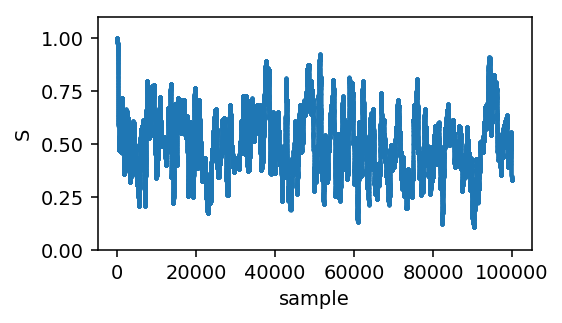

In [27]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.scatter(
    numpy.arange(len(s1)), 
    s1, s=1);

pyplot.xlabel('sample');
pyplot.ylabel('S');
pyplot.ylim((0,1.1));

### Density of the system

In [ ]:
particles = snap.particles.N

lx = snap.box.Lx
ly = snap.box.Ly
lz = snap.box.Lz
volume = lx * ly *lz

density = particles / volume
print('Particles = ', particles)
print("Volume = ",volume)
print("Density = ", density)